# [**Introduction à l'ingénierie manuelle de caractéristiques (partie 1)**](https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering/notebook)

809 votes

# Introduction : Ingénierie manuelle des caractéristiques

Si vous êtes nouveau dans cette compétition, je vous recommande vivement de consulter [**ce notebook**](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction/) pour commencer.

Dans ce notebook, nous allons explorer la création manuelle de caractéristiques pour la compétition Home Credit Default Risk. Dans un notebook précédent, nous avons utilisé uniquement les données `application` pour construire un modèle. Le meilleur modèle que nous ayons obtenu à partir de ces données a obtenu un score d'environ 0,74 sur le classement. Afin d'améliorer ce score, nous devrons inclure plus d'informations à partir des autres ensembles de données. Ici, nous allons examiner l'utilisation d'informations provenant des données `bureau` et `bureau_balance`. Les définitions de ces fichiers de données sont les suivantes :

* `bureau` : informations sur les prêts précédents du client auprès d'autres institutions financières signalées à Home Credit. Chaque prêt précédent a sa propre ligne.
* `bureau_balance` : informations mensuelles sur les prêts précédents. Chaque mois a sa propre ligne.

L'ingénierie manuelle des caractéristiques peut être un processus laborieux (c'est pourquoi nous utilisons l'ingénierie automatisée des caractéristiques avec `featuretools` !) et repose souvent sur une expertise métier. Étant donné que mes connaissances en matière de prêts et de ce qui rend une personne susceptible de faire défaut sont limitées, je vais plutôt me concentrer sur l'obtention du maximum d'informations dans le dernier ensemble d'entraînement. L'idée est que le modèle sera alors capable de détecter les caractéristiques importantes plutôt que de devoir les choisir nous-mêmes. En gros, notre approche consiste à créer autant de caractéristiques que possible, puis à les fournir toutes au modèle ! Plus tard, nous pourrons réduire les caractéristiques en utilisant les importances des caractéristiques issues du modèle ou d'autres techniques telles que l'ACP.

Le processus d'ingénierie manuelle des caractéristiques impliquera beaucoup de code Pandas, un peu de patience et beaucoup de pratique pour manipuler les données. Même si des outils d'ingénierie automatisée des caractéristiques commencent à être disponibles, l'ingénierie des caractéristiques devra encore être réalisée en manipulant beaucoup de données pendant un certain temps.

In [16]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

## Exemple : Nombre de prêts précédents d'un client

Pour illustrer le processus général d'ingénierie manuelle des caractéristiques, nous allons d'abord simplement obtenir le nombre de prêts précédents d'un client auprès d'autres institutions financières. Cela nécessite plusieurs opérations Pandas que nous utiliserons largement dans ce notebook :

- `groupby` : regroupe un dataframe suivant une colonne. Dans ce cas, nous allons regrouper par client unique (la colonne `SK_ID_CURR`).
- `agg` : effectue un calcul sur les données regroupées, tel que la moyenne des colonnes. Nous pouvons appeler la fonction directement (`grouped_df.mean()`) ou utiliser la fonction `agg` avec une liste de transformations (`grouped_df.agg([mean, max, min, sum])`).
- `merge` : fait correspondre les statistiques agrégées au client approprié. Nous devons fusionner les données d'entraînement d'origine avec les statistiques calculées sur la colonne `SK_ID_CURR`, ce qui insérera `NaN` dans toutes les cellules pour lesquelles le client n'a pas la statistique correspondante.

Nous utilisons également fréquemment la fonction (`rename`) en spécifiant les colonnes à renommer sous forme de dictionnaire. C'est pratique pour garder une trace des nouvelles variables que nous créons.

Cela peut sembler beaucoup, c'est pourquoi nous finirons par écrire une fonction pour effectuer ce processus pour nous. Commençons par implémenter cela manuellement.

In [17]:
# Read in bureau
bureau = pd.read_csv('../../dataset/csv/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [18]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = (
    bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU']
    .count().rename(columns={'SK_ID_BUREAU': 'previous_loan_counts'})
)
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [19]:
# Join to the training dataframe
train = pd.read_csv('../../dataset/csv/application_train.csv')
train = train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Veuillez faire défiler complètement vers la droite pour voir la nouvelle colonne.

## Évaluation de l'utilité de la nouvelle variable avec la valeur $r$

Pour déterminer si la nouvelle variable est utile, nous pouvons calculer le coefficient de corrélation de Pearson (valeur $r$) entre cette variable et la variable cible. Cela mesure la force de la relation linéaire entre deux variables et varie de -1 (linéairement négatif parfait) à +1 (linéairement positif parfait). La valeur $r$ n'est pas la meilleure mesure de l'"utilité" d'une nouvelle variable, mais elle peut donner une première approximation de l'utilité d'une variable pour un modèle d'apprentissage automatique. Plus la valeur $r$ d'une variable par rapport à la variable cible est grande, plus un changement dans cette variable est susceptible d'affecter la valeur de la variable cible. Par conséquent, nous recherchons les variables ayant la plus grande valeur absolue de $r$ par rapport à la variable cible.

Nous pouvons également examiner visuellement la relation avec la variable cible en utilisant le tracé de l'estimation de la densité du noyau (KDE).

### Tracés de l'estimation de la densité du noyau (KDE)

Le tracé de l'estimation de la densité du noyau montre la distribution d'une seule variable (pensez-y comme un histogramme lissé). Pour voir les différences de distributions en fonction de la valeur d'une variable catégorielle, nous pouvons colorer les distributions différemment selon la catégorie. Par exemple, nous pouvons montrer l'estimation de la densité du noyau du `previous_loan_count` colorée en fonction de si la variable `TARGET` vaut 1 ou 0. Le KDE résultant montrera les différences significatives dans la distribution de la variable entre les personnes qui n'ont pas remboursé leur prêt (`TARGET == 1`) et celles qui l'ont fait (`TARGET == 0`). Cela peut servir d'indicateur de la "pertinence" d'une variable pour un modèle d'apprentissage automatique.

Nous mettrons cette fonctionnalité de tracé dans une fonction afin de pouvoir la réutiliser pour n'importe quelle variable.

In [20]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])

    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()

    plt.figure(figsize = (12, 6))

    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')

    # label the plot
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title(f'{var_name} Distribution')
    plt.legend()

    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

Nous pouvons tester cette fonction en utilisant la variable `EXT_SOURCE_3`, qui a été [identifiée comme l'une des variables les plus importantes](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction) selon une forêt aléatoire et un gradient boosting.

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


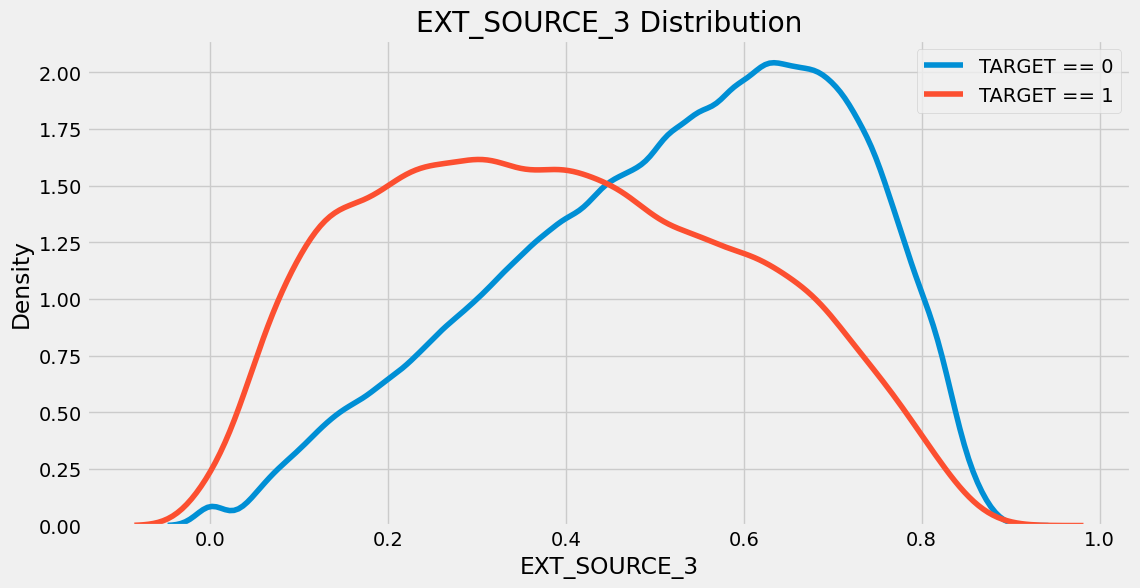

In [21]:
kde_target('EXT_SOURCE_3', train)

Pour la nouvelle variable que nous venons de créer, le nombre de prêts précédents dans d'autres établissements.

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


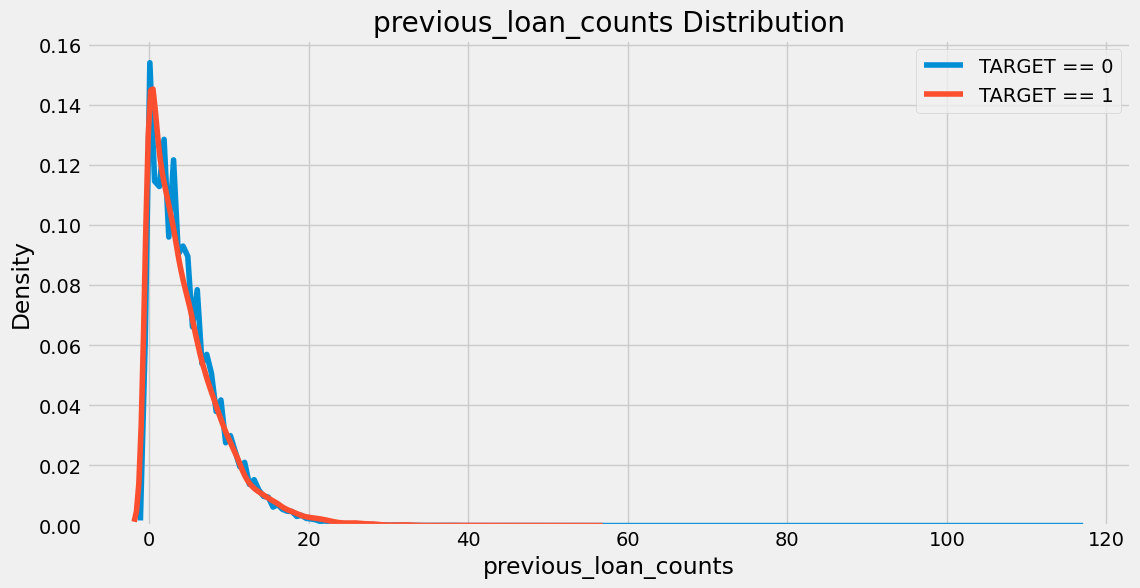

In [22]:
kde_target('previous_loan_counts', train)

Partant de là, il est difficile de dire si cette variable sera importante. Le coefficient de corrélation est extrêmement faible et il n'y a presque aucune différence visible dans les distributions.

Passons maintenant à la création de quelques variables supplémentaires à partir du dataframe `bureau`. Nous prendrons la moyenne, le minimum et le maximum de chaque colonne numérique du dataframe `bureau`.

### Agrégation des colonnes numériques

Pour tenir compte des informations numériques dans le dataframe `bureau`, nous pouvons calculer des statistiques pour toutes les colonnes numériques. Pour ce faire, nous regroupons les données par identifiant de client à l'aide de la fonction `groupby`, nous appliquons l'agrégation sur le groupe de données à l'aide de la fonction `agg`, et nous fusionnons le résultat avec les données d'entraînement. La fonction `agg` calculera uniquement les valeurs pour les colonnes numériques pour lesquelles l'opération est considérée comme valide. Nous utiliserons les fonctions `'mean'`, `'max'`, `'min'`, `'sum'`, mais toute fonction peut être utilisée ici. Nous pouvons même écrire notre propre fonction et l'utiliser dans un appel à `agg`.

In [23]:
# Group by the client id, calculate aggregation statistics
bureau_agg = (
    bureau.drop(columns=['SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'])
    .groupby('SK_ID_CURR', as_index=False)
    .agg(['count', 'mean', 'max', 'min', 'sum'])
    .reset_index()
)
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE   
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7  \
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                                
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652  \
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

Nous devons créer de nouveaux noms pour chacune de ces colonnes. Le code suivant crée de nouveaux noms en ajoutant la statistique au nom. Ici, nous devons tenir compte du fait que le dataframe a un index à plusieurs niveaux. Je trouve cela confus et difficile à manipuler, donc j'essaie de le réduire à un index à un seul niveau le plus rapidement possible.

In [24]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        # Iterate through the stat names
        columns.extend(
            f'bureau_{var}_{stat}'
            for stat in bureau_agg.columns.levels[1][:-1]
        )

In [25]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Maintenant, nous fusionnons simplement avec les données d'entraînement comme nous l'avons fait précédemment.

In [26]:
# Merge with the training data
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### Corrélations des valeurs agrégées avec la variable cible

Nous pouvons calculer la corrélation de toutes les nouvelles valeurs avec la variable cible. Une fois de plus, nous pouvons utiliser ces corrélations comme approximation des variables qui peuvent être importantes pour la modélisation.

In [27]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])

    # Append the list as a tuple
    new_corrs.append((col, corr))

Dans le code ci-dessous, nous trions les corrélations par magnitude (valeur absolue) en utilisant la fonction `sorted` de Python. Nous utilisons également une fonction anonyme `lambda`, une autre opération importante en Python qu'il est bon de connaître.

In [28]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key=lambda x: abs(x[1]), reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.089728967219981),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010374),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968684),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920795),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020585),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758622),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997309),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115936),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483553),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073023),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484667),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.0414036353530601),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632898),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332547)]

Aucune des nouvelles variables n'a de corrélation significative avec la variable `TARGET`. Nous pouvons examiner le tracé KDE de la variable la plus corrélée, `bureau_DAYS_CREDIT_mean`, avec la variable cible en termes de corrélation de magnitude absolue.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


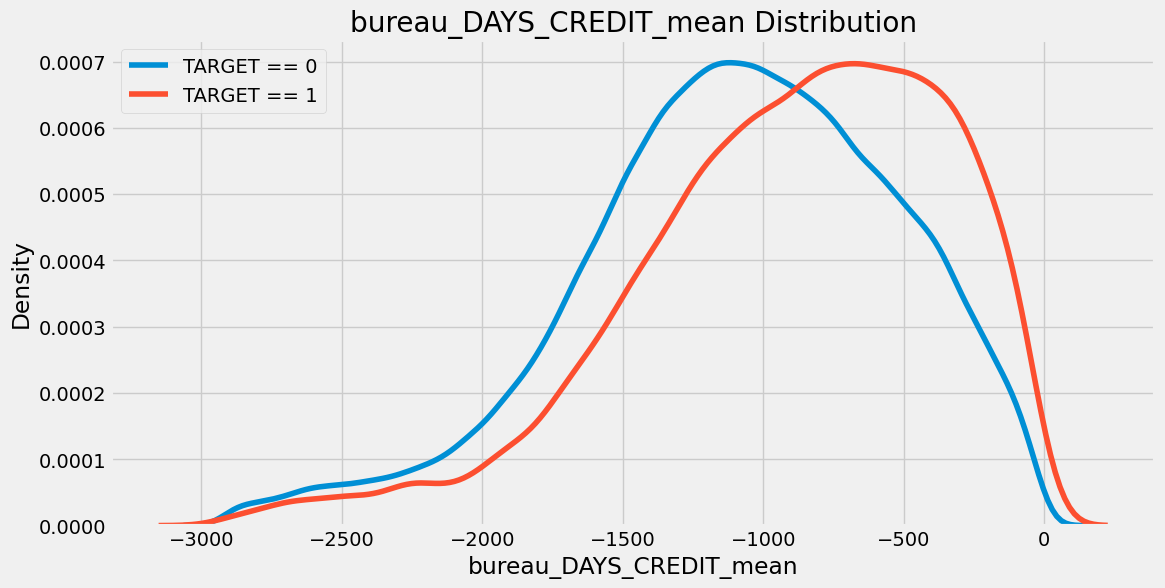

In [29]:
kde_target('bureau_DAYS_CREDIT_mean', train)

La définition de cette colonne est : "Combien de jours avant la demande actuelle le client a-t-il demandé un crédit au "Bureau de crédit". J'interprète cela comme le nombre de jours écoulés entre la demande de prêt précédente et la demande de prêt actuelle chez Home Credit. Par conséquent, un nombre négatif plus grand indique que le prêt a été demandé plus longtemps avant la demande de prêt actuelle. Nous constatons une relation extrêmement faible et positive entre la moyenne de cette variable et la variable cible, ce qui signifie que les clients qui ont demandé des prêts plus longtemps dans le passé sont potentiellement plus susceptibles de rembourser les prêts chez Home Credit. Cependant, avec une corrélation aussi faible, il est aussi probable que cela soit du bruit plutôt qu'un signal.

#### Le problème des comparaisons multiples

Lorsque nous avons beaucoup de variables, nous nous attendons à ce que certaines d'entre elles soient corrélées simplement par pur hasard, un [problème connu sous le nom de problèmes de comparaisons multiples](https://towardsdatascience.com/the-multiple-comparisons-problem-e5573e8b9578). Nous pouvons créer des centaines de caractéristiques, et certaines se révéleront être corrélées avec la variable cible simplement en raison du bruit aléatoire dans les données. Ensuite, lorsque notre modèle s'entraîne, il peut surajuster ces variables car il pense qu'elles ont une relation avec la variable cible dans l'ensemble d'entraînement, mais cela ne se généralise pas nécessairement à l'ensemble de test. Il y a de nombreux éléments à prendre en compte lors de la création de caractéristiques !

## Fonction pour les agrégations numériques

Encapsulons tout le travail précédent dans une fonction. Cela nous permettra de calculer des statistiques agrégées pour les colonnes numériques de n'importe quel dataframe. Nous réutiliserons cette fonction lorsque nous voudrons appliquer les mêmes opérations à d'autres dataframes.

In [30]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)

    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            columns.extend(
                f'{df_name}_{var}_{stat}'
                for stat in agg.columns.levels[1][:-1]
            )
    agg.columns = columns
    return agg

In [31]:
bureau_agg_new = agg_numeric(
    bureau.drop(columns=['SK_ID_BUREAU']),
    group_var='SK_ID_CURR',
    df_name='bureau'
)
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Pour nous assurer que la fonction a bien fonctionné comme prévu, nous devrions la comparer avec le dataframe agrégé que nous avons construit manuellement.

In [32]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


Si nous passons en revue et inspectons les valeurs, nous constatons qu'elles sont équivalentes. Nous pourrons réutiliser cette fonction pour calculer des statistiques numériques pour d'autres dataframes. L'utilisation de fonctions permet d'obtenir des résultats cohérents et réduit la quantité de travail à effectuer à l'avenir !

### Fonction de corrélation

Avant de passer à la suite, nous pouvons également créer une fonction pour calculer les corrélations avec la variable cible.

In [33]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))

    return sorted(corrs, key=lambda x: abs(x[1]), reverse=True)

## Variables catégorielles

Nous passons maintenant des colonnes numériques aux colonnes catégorielles. Il s'agit de variables discrètes de type chaîne de caractères, donc nous ne pouvons pas simplement calculer des statistiques telles que la moyenne et le maximum qui ne fonctionnent qu'avec des variables numériques. À la place, nous compterons le nombre de chaque catégorie dans chaque variable catégorielle. Par exemple, si nous avons le dataframe suivant :

| SK_ID_CURR | Type de prêt |
|------------|--------------|
| 1          | maison       |
| 1          | maison       |
| 1          | maison       |
| 1          | crédit       |
| 2          | crédit       |
| 3          | crédit       |
| 3          | espèces      |
| 3          | espèces      |
| 4          | crédit       |
| 4          | maison       |
| 4          | maison       |

nous utiliserons ces informations pour compter le nombre de prêts dans chaque catégorie pour chaque client.

| SK_ID_CURR | nombre de crédits | nombre d'espèces | nombre de maisons | nombre total |
|------------|-------------------|-----------------|------------------|--------------|
| 1          | 1                 | 0               | 3                | 4            |
| 2          | 1                 | 0               | 0                | 1            |
| 3          | 1                 | 2               | 0                | 3            |
| 4          | 1                 | 0               | 2                | 3            |


Ensuite, nous pouvons normaliser ces décomptes en divisant par le nombre total d'occurrences de cette variable catégorielle pour cette observation (ce qui signifie que les décomptes normalisés doivent s'additionner à 1.0 pour chaque observation).

| SK_ID_CURR | nombre de crédits | nombre d'espèces | nombre de maisons | nombre total | nombre de crédits normalisé | nombre d'espèces normalisé | nombre de maisons normalisé |
|------------|-------------------|-----------------|------------------|--------------|----------------------------|--------------------------|---------------------------|
| 1          | 1                 | 0               | 3                | 4            | 0.25                       | 0                        | 0.75                      |
| 2          | 1                 | 0               | 0                | 1            | 1.00                       | 0                        | 0                          |
| 3          | 1                 | 2               | 0                | 3            | 0.33                       | 0.66                     | 0                          |
| 4          | 1                 | 0               | 2                | 3            | 0.33                       | 0                        | 0.66                       |

Espérons que cette encodage des variables catégorielles nous permettra de capturer les informations qu'elles contiennent. Si quelqu'un a une meilleure idée pour ce processus, veuillez me le faire savoir dans les commentaires ! Nous allons maintenant passer en revue ce processus étape par étape. À la fin, nous regrouperons tout le code dans une seule fonction afin de le réutiliser pour de nombreux dataframes.

Tout d'abord, nous effectuons un encodage one-hot d'un dataframe contenant uniquement les colonnes catégorielles (`dtype == 'object'`).

In [34]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,False,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
1,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
2,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
3,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354
4,True,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,215354


In [35]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt        
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0  \
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold        
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0  \
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan        
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0  \
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage        
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0  \
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan   
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0  \
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

Les colonnes "sum" représentent le décompte de cette catégorie pour le client correspondant et la colonne "mean" représente le décompte normalisé. L'encodage one-hot facilite grandement le calcul de ces valeurs !

Nous pouvons utiliser une fonction similaire à celle utilisée précédemment pour renommer les colonnes. Encore une fois, nous devons gérer l'index multi-niveaux des colonnes. Nous itérons sur le premier niveau (niveau 0) qui correspond au nom de la variable catégorielle suivi de la valeur de la catégorie (issue de l'encodage one-hot). Ensuite, nous itérons sur les statistiques que nous avons calculées pour chaque client. Nous renommons la colonne avec le nom du niveau 0 suivi de la statistique. Par exemple, la colonne avec `CREDIT_ACTIVE_Active` en niveau 0 et `sum` en niveau 1 deviendra `CREDIT_ACTIVE_Active_count`.

In [36]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [37]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [38]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        columns.extend(f'{var}_{stat}' for stat in ['count', 'count_norm'])
#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


La colonne "sum" enregistre les décomptes et la colonne "mean" enregistre les décomptes normalisés.

Nous pouvons fusionner ce dataframe avec les données d'entraînement.

In [39]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
train.shape

(307511, 229)

In [41]:
train.iloc[:10, 123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fonction pour gérer les variables catégorielles

Pour rendre le code plus efficace, nous pouvons maintenant écrire une fonction pour gérer les variables catégorielles à notre place. Cette fonction aura la même structure que la fonction `agg_numeric`, c'est-à-dire qu'elle acceptera un dataframe et une variable de regroupement. Ensuite, elle calculera les décomptes et les décomptes normalisés de chaque catégorie pour toutes les variables catégorielles du dataframe.

In [42]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])

    column_names = []

    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        column_names.extend(
            f'{df_name}_{var}_{stat}' for stat in ['count', 'count_norm']
        )
    categorical.columns = column_names

    return categorical

In [43]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Application des opérations à un autre dataframe

Nous allons maintenant nous pencher sur le dataframe "bureau_balance". Ce dataframe contient des informations mensuelles sur les prêts précédents de chaque client avec d'autres institutions financières. Au lieu de regrouper ce dataframe par "SK_ID_CURR" qui est l'identifiant du client, nous allons d'abord regrouper le dataframe par "SK_ID_BUREAU" qui est l'identifiant du prêt précédent. Cela nous donnera une ligne du dataframe pour chaque prêt. Ensuite, nous pouvons regrouper par "SK_ID_CURR" et calculer les agrégations sur les prêts de chaque client. Le résultat final sera un dataframe avec une ligne pour chaque client, avec des statistiques calculées pour ses prêts.

In [44]:
# Read in bureau balance
bureau_balance = pd.read_csv('../../dataset/csv/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Tout d'abord, nous pouvons calculer les décomptes de chaque statut pour chaque prêt. Heureusement, nous avons déjà une fonction qui fait cela pour nous !

In [45]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


Maintenant, nous pouvons traiter la colonne numérique. La colonne `MONTHS_BALANCE` représente "le nombre de mois depuis la date de demande". Cela peut ne pas être nécessairement important en tant que variable numérique, et dans les travaux futurs, nous pourrions envisager de la traiter comme une variable temporelle. Pour l'instant, nous pouvons simplement calculer les mêmes statistiques d'agrégation que précédemment.

In [46]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


Les dataframes ci-dessus contiennent les calculs effectués sur chaque _prêt_. Maintenant, nous devons les agréger pour chaque _client_. Nous pouvons le faire en fusionnant d'abord les dataframes, puis en agrégeant à nouveau les statistiques, cette fois en regroupant par "SK_ID_CURR".

In [47]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on='SK_ID_BUREAU', how='outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on='SK_ID_BUREAU', how='left')

bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [48]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41,4,0.254545,1.000000,0.0,1.018182


Pour récapituler, pour le dataframe `bureau_balance` :

1. Nous avons calculé des statistiques numériques en regroupant par chaque prêt.
2. Nous avons effectué des décomptes pour chaque variable catégorielle en regroupant par prêt.
3. Nous avons fusionné les statistiques et les décomptes en utilisant les prêts.
4. Nous avons calculé des statistiques numériques pour le dataframe résultant en regroupant par l'identifiant du client.

Le dataframe final obtenu contient une ligne pour chaque client, avec des statistiques calculées pour l'ensemble de ses prêts avec des informations de solde mensuel.

Certaines de ces variables sont un peu déroutantes, alors essayons de les expliquer :

- `client_bureau_balance_MONTHS_BALANCE_mean_mean` : Pour chaque prêt, calculer la valeur moyenne de `MONTHS_BALANCE`. Ensuite, pour chaque client, calculer la moyenne de cette valeur pour l'ensemble de ses prêts.
- `client_bureau_balance_STATUS_X_count_norm_sum` : Pour chaque prêt, calculer le nombre d'occurrences où "STATUS" est égal à X divisé par le nombre total de valeurs de `STATUS` pour le prêt. Ensuite, pour chaque client, additionner les valeurs pour chaque prêt.

Nous attendrons de calculer les corrélations jusqu'à ce que nous ayons toutes les variables regroupées dans un seul dataframe.

# Regrouper les fonctions

Nous avons maintenant toutes les pièces en place pour prendre les informations sur les prêts précédents auprès d'autres institutions et les informations mensuelles de paiement de ces prêts, et les intégrer dans le dataframe d'entraînement principal. Faisons une réinitialisation de toutes les variables, puis utilisons les fonctions que nous avons construites pour réaliser cela à partir de zéro. Cela démontre l'avantage d'utiliser des fonctions pour des workflows reproductibles !

In [49]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

8080

In [50]:
# Read in new copies of all the dataframes
train = pd.read_csv('../../dataset/csv/application_train.csv')
bureau = pd.read_csv('../../dataset/csv/bureau.csv')
bureau_balance = pd.read_csv('../../dataset/csv/bureau_balance.csv')

### Décomptes du dataframe "bureau"

In [51]:
bureau_counts = count_categorical(bureau, group_var='SK_ID_CURR', df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Statistiques agrégées du dataframe "bureau"

In [52]:
bureau_agg = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Décomptes du dataframe "bureau_balance" par prêt

In [53]:
bureau_balance_counts = count_categorical(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


### Statistiques agrégées du dataframe "bureau_balance" par prêt

In [54]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


### Statistiques agrégées du dataframe "bureau_balance" par client

In [55]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on='SK_ID_BUREAU', how='outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on='SK_ID_BUREAU', how='left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='client')

## Insérer les variables calculées dans les données d'entraînement

In [56]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [57]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on='SK_ID_CURR', how='left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')

In [58]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


# Résultats de l'ingénierie des variables

Après tout ce travail, nous souhaitons maintenant examiner les variables que nous avons créées. Nous pouvons observer le pourcentage de valeurs manquantes, les corrélations des variables avec la variable cible, ainsi que les corrélations entre les variables elles-mêmes. Les corrélations entre les variables peuvent révéler l'existence de variables collinéaires, c'est-à-dire des variables fortement corrélées les unes avec les autres. Souvent, nous souhaitons supprimer l'une des variables collinéaires, car avoir les deux variables serait redondant. Nous pouvons également utiliser le pourcentage de valeurs manquantes pour supprimer les variables avec une grande majorité de valeurs non présentes. La **sélection des variables** sera un point important à prendre en compte par la suite, car la réduction du nombre de variables peut aider le modèle à apprendre lors de l'entraînement et à généraliser de manière plus précise sur les données de test. Le "fléau de la dimensionnalité" est le terme utilisé pour désigner les problèmes causés par le fait d'avoir trop de variables (une dimension trop élevée). À mesure que le nombre de variables augmente, le nombre de points de données nécessaires pour apprendre la relation entre ces variables et la valeur cible augmente de manière exponentielle.

La sélection des variables est le processus consistant à supprimer des variables pour aider notre modèle à apprendre et à généraliser de manière plus précise sur l'ensemble de test. L'objectif est de supprimer les variables inutiles/redondantes tout en préservant celles qui sont utiles. Il existe plusieurs outils que nous pouvons utiliser pour ce processus, mais dans ce notebook, nous nous concentrerons sur la suppression des colonnes avec un pourcentage élevé de valeurs manquantes et des variables qui présentent une forte corrélation entre elles. Plus tard, nous pourrons utiliser les importances des variables renvoyées par des modèles tels que le "Gradient Boosting Machine" ou la "Random Forest" pour effectuer la sélection des variables.

## Valeurs manquantes

Une considération importante concerne les valeurs manquantes dans le dataframe. Les colonnes avec trop de valeurs manquantes pourraient devoir être supprimées.

In [59]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print(
            ((f"Your selected dataframe has {str(df.shape[1])}" + " columns.\n"
              "There are ") + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values."))

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [60]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


Nous constatons qu'il y a plusieurs colonnes avec un pourcentage élevé de valeurs manquantes. Il n'existe pas de seuil bien défini pour la suppression des valeurs manquantes, et la meilleure action à entreprendre dépend du problème. Ici, afin de réduire le nombre de variables, nous supprimerons toutes les colonnes dans les données d'entraînement ou de test qui ont plus de 90% de valeurs manquantes.

In [61]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

Avant de supprimer les valeurs manquantes, nous calculerons le pourcentage de valeurs manquantes dans les données de test. Ensuite, nous supprimerons toutes les colonnes ayant plus de 90% de valeurs manquantes dans les données d'entraînement ou de test.

Laissez-nous maintenant lire les données de test, effectuer les mêmes opérations et examiner les valeurs manquantes dans les données de test. Nous avons déjà calculé tous les décomptes et les statistiques d'agrégation, il nous suffit donc de fusionner les données de test avec les données appropriées.

## Calculer les informations pour les données de test

In [62]:
# Read in the test dataframe
test = pd.read_csv('../../dataset/csv/application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on='SK_ID_CURR', how='left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')

In [63]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


Nous devons aligner les dataframes de test et d'entraînement, ce qui signifie les faire correspondre afin qu'ils aient exactement les mêmes colonnes. Cela ne devrait pas poser de problème ici, mais lorsque nous encodons les variables en one-hot, nous devons aligner les dataframes pour nous assurer qu'ils ont les mêmes colonnes.

In [64]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join='inner', axis=1)

train['TARGET'] = train_labels

In [65]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


Les dataframes ont maintenant les mêmes colonnes (à l'exception de la colonne `TARGET` dans les données d'entraînement). Cela signifie que nous pouvons les utiliser dans un modèle d'apprentissage automatique qui doit voir les mêmes colonnes dans les dataframes d'entraînement et de test.

Regardons maintenant le pourcentage de valeurs manquantes dans les données de test afin de déterminer les colonnes qui doivent être supprimées.

In [66]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [67]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [68]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [69]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

Nous n'avons finalement supprimé aucune colonne à ce stade car il n'y a aucune colonne avec plus de 90% de valeurs manquantes. Il se peut que nous devions appliquer une autre méthode de sélection de variables pour réduire la dimensionnalité.

À ce stade, nous allons sauvegarder à la fois les données d'entraînement et les données de test. Je vous encourage à essayer différentes proportions pour supprimer les colonnes manquantes et à comparer les résultats.

In [ ]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

## Corrélations

Tout d'abord, examinons les corrélations des variables avec la variable cible. Nous pouvons voir que aucune des variables que nous avons créées n'a une corrélation plus élevée que celles déjà présentes dans les données d'entraînement (provenant de `application`).

In [70]:
display(train)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum,TARGET
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,1.875000,3.0,0.0,15.0,8.0,0.161932,0.500000,0.000000,1.295455,1
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.000000,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.000000,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
307507,456252,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
307508,456253,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,3.250000,13.0,0.0,13.0,4.0,0.135417,0.541667,0.000000,0.541667,0
307509,456254,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,...,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1


In [71]:
import numpy as np
train_ = train.select_dtypes(include=[np.number])
display(train_)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum,TARGET
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,1.875000,3.0,0.0,15.0,8.0,0.161932,0.500000,0.000000,1.295455,1
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.000000,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.000000,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
307507,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
307508,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,...,3.250000,13.0,0.0,13.0,4.0,0.135417,0.541667,0.000000,0.541667,0
307509,456254,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,...,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,1


In [72]:
# Calculate all correlations in dataframe
corrs = train_.corr()

In [73]:
corrs = corrs.sort_values('TARGET', ascending=False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [74]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


La variable la plus corrélée avec la variable cible (à l'exception de la variable `TARGET`, qui a bien sûr une corrélation de 1) est une variable que nous avons créée. Cependant, le fait qu'une variable soit corrélée ne signifie pas qu'elle sera utile, et nous devons nous rappeler que si nous générons des centaines de nouvelles variables, certaines seront corrélées avec la variable cible simplement en raison du bruit aléatoire.

En examinant les corrélations de manière sceptique, il semble que plusieurs des nouvelles variables créées puissent être utiles. Pour évaluer "l'utilité" des variables, nous examinerons les importances des variables renvoyées par le modèle. Par curiosité (et parce que nous avons déjà écrit la fonction), nous pouvons créer un tracé KDE (Kernel Density Estimate) de deux des nouvelles variables créées.

The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.0802
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid =     25.1429


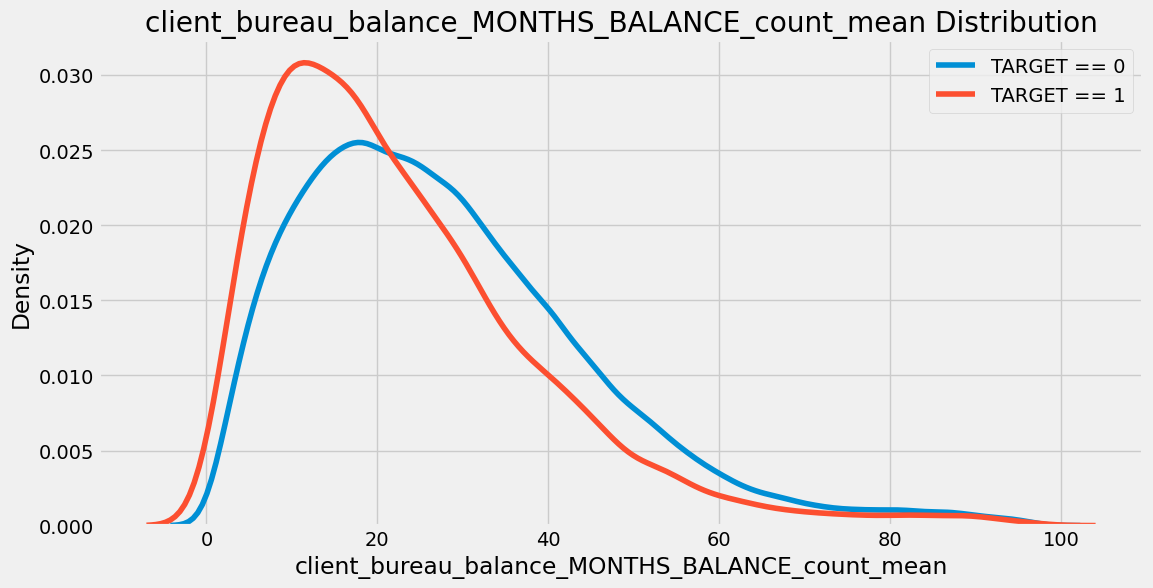

In [75]:
kde_target(var_name='client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

Cette variable représente le nombre moyen d'enregistrements mensuels par prêt pour chaque client. Par exemple, si un client avait trois prêts précédents avec 3, 4 et 5 enregistrements dans les données mensuelles, la valeur de cette variable pour ce client serait de 4. D'après la distribution, les clients ayant un plus grand nombre moyen d'enregistrements mensuels par prêt étaient plus susceptibles de rembourser leurs prêts avec Home Credit. Ne donnons pas trop d'importance à cette valeur, mais cela pourrait indiquer que les clients ayant une historique de crédit plus longue sont généralement plus susceptibles de rembourser un prêt.

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.3636


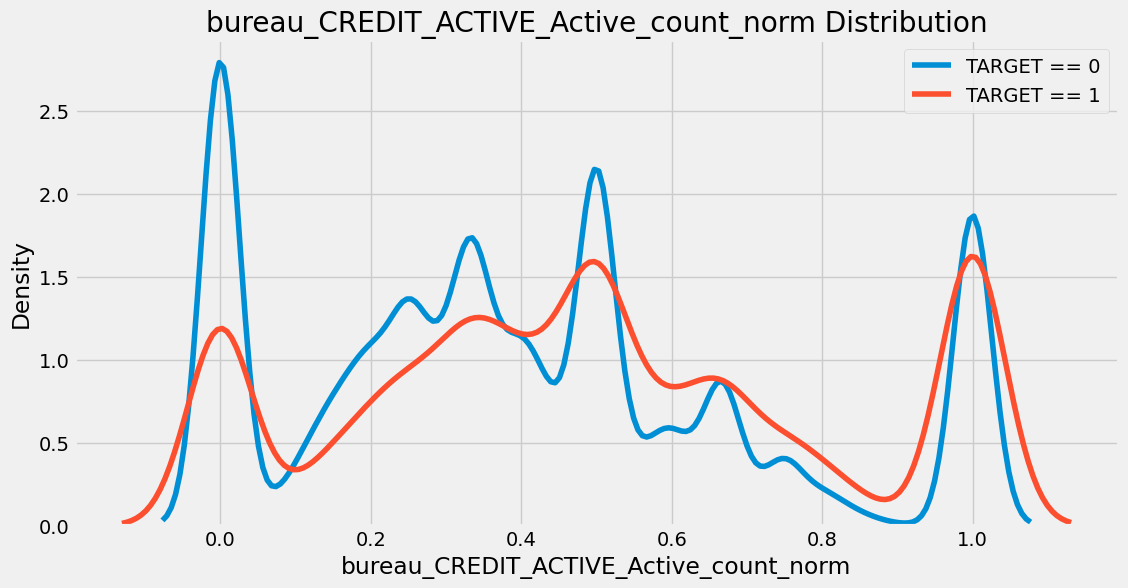

In [76]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

Eh bien, cette distribution est très variable. Cette variable représente le nombre de prêts précédents avec une valeur `CREDIT_ACTIVE` égale à `Active` divisé par le nombre total de prêts précédents pour un client. La corrélation ici est tellement faible que je ne pense pas que nous devrions tirer de conclusions !

### Variables collinéaires

Nous pouvons calculer non seulement les corrélations des variables avec la variable cible, mais aussi la corrélation de chaque variable avec toutes les autres variables. Cela nous permettra de voir s'il existe des variables fortement collinéaires qui devraient peut-être être supprimées des données.

Cherchons les variables qui ont une corrélation supérieure à 0,8 avec d'autres variables.

In [77]:
# Set the threshold
threshold = 0.8

above_threshold_vars = {
    col: list(corrs.index[corrs[col] > threshold]) for col in corrs
}

Pour chacune de ces paires de variables fortement corrélées, nous ne voulons supprimer qu'une seule des variables. Le code suivant crée un ensemble de variables à supprimer en n'ajoutant qu'une seule variable de chaque paire.

In [78]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        elif x not in cols_seen:
            cols_to_remove.append(x)
            cols_to_remove_pair.append(key)

cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


Nous pouvons supprimer ces colonnes à la fois des ensembles d'entraînement et de test. Nous devrons comparer les performances après avoir supprimé ces variables avec les performances en conservant ces variables (les fichiers CSV bruts que nous avons sauvegardés précédemment).

In [79]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [ ]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index=False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index=False)

# Modélisation

Pour tester réellement les performances de ces nouveaux ensembles de données, nous allons les utiliser pour l'apprentissage automatique ! Ici, nous utiliserons une fonction que j'ai développée dans un autre notebook pour comparer les caractéristiques (la version brute avec les variables fortement corrélées supprimées). Nous pouvons exécuter cela comme une sorte d'expérience, et le groupe de contrôle sera la performance des seules données de l'ensemble `application` dans cette fonction lorsqu'elle est soumise au concours. J'ai déjà enregistré cette performance, nous pouvons donc lister notre groupe de contrôle et nos deux conditions de test :

__Pour tous les ensembles de données, utilisez le modèle indiqué ci-dessous (avec les hyperparamètres exacts).__

* **Groupe de contrôle** : seulement les données de la table `application`.
* **Test un** : les données de la table `application` avec toutes les données enregistrées des tables `bureau` et `bureau_balance`.
* **Test deux** : les données de la table `application` avec toutes les données enregistrées des tables `bureau` et `bureau_balance` avec les variables fortement corrélées supprimées.

In [80]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [81]:
def model(features, test_features, encoding='ohe', n_folds=5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default='ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns=['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns=['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join='inner', axis=1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective='binary', 
                                   class_weight= 'balanced', learning_rate=0.05, 
                                   reg_alpha=0.1, reg_lambda=0.1, 
                                   subsample=0.8, n_jobs=-1, random_state=50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric='auc',
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], categorical_feature=cat_indices,
                  early_stopping_rounds=100, verbose=200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration=best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration=best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [82]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

### Contrôle

La première étape de toute expérience est d'établir un groupe de contrôle. Pour cela, nous utiliserons la fonction définie ci-dessus (qui implémente un modèle de Gradient Boosting Machine) et la source principale de données (`application`).

In [83]:
train_control = pd.read_csv('../../dataset/csv/application_train.csv')
test_control = pd.read_csv('../../dataset/csv/application_test.csv')

Heureusement, une fois que nous avons pris le temps d'écrire une fonction, son utilisation est simple (si vous avez remarqué un thème central dans ce notebook, c'est d'utiliser des fonctions pour simplifier les choses et les rendre reproductibles !). La fonction ci-dessus renvoie un dataframe `submission` que nous pouvons télécharger sur la plateforme du concours, un dataframe `fi` des importances de features, et un dataframe `metrics` avec les performances de validation et de test.

In [84]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
[200]	train's auc: 0.7989	train's binary_logloss: 0.547642	valid's auc: 0.755463	valid's binary_logloss: 0.563361
[400]	train's auc: 0.82864	train's binary_logloss: 0.518235	valid's auc: 0.755594	valid's binary_logloss: 0.544951
[200]	train's auc: 0.798638	train's binary_logloss: 0.547974	valid's auc: 0.758354	valid's binary_logloss: 0.56326
[200]	train's auc: 0.7977	train's binary_logloss: 0.549358	valid's auc: 0.763287	valid's binary_logloss: 0.564505
[200]	train's auc: 0.798947	train's binary_logloss: 0.547854	valid's auc: 0.757824	valid's binary_logloss: 0.562314
[200]	train's auc: 0.798357	train's binary_logloss: 0.548311	valid's auc: 0.758236	valid's binary_logloss: 0.564467


In [85]:
metrics

,fold,train,valid
0,0,0.815791,0.755755
1,1,0.811912,0.758533
2,2,0.811252,0.763822
3,3,0.805899,0.758346
4,4,0.807459,0.758534
5,overall,0.810463,0.759002


Le groupe de contrôle présente légèrement un surajustement car le score d'entraînement est plus élevé que le score de validation. Nous pourrons aborder cela dans les prochains notebooks lorsque nous examinerons la régularisation (nous effectuons déjà une certaine régularisation dans ce modèle en utilisant `reg_lambda` et `reg_alpha`, ainsi que l'arrêt anticipé).

Nous pouvons visualiser l'importance des features avec une autre fonction, `plot_feature_importances`. Les importances des features peuvent être utiles lorsqu'il est temps de sélectionner les features.

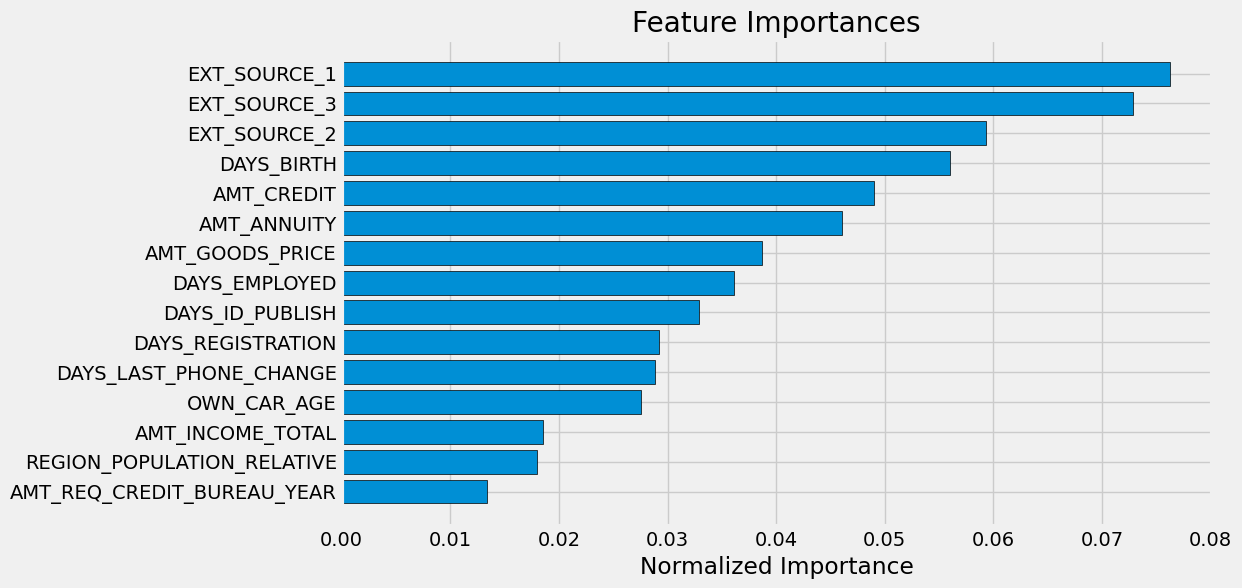

In [86]:
fi_sorted = plot_feature_importances(fi)

In [87]:
submission.to_csv('control.csv', index=False)

__Le groupe de contrôle obtient un score de 0,745 lorsqu'il est soumis au concours.__

### Test Un

Passons maintenant au premier test. Nous devrons simplement passer les données à la fonction, qui fera la plupart du travail pour nous.

In [88]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
[200]	train's auc: 0.810821	train's binary_logloss: 0.53617	valid's auc: 0.763279	valid's binary_logloss: 0.553134
[200]	train's auc: 0.810727	train's binary_logloss: 0.53666	valid's auc: 0.765248	valid's binary_logloss: 0.553448
[200]	train's auc: 0.809569	train's binary_logloss: 0.538079	valid's auc: 0.770517	valid's binary_logloss: 0.55476
[200]	train's auc: 0.810367	train's binary_logloss: 0.537096	valid's auc: 0.765832	valid's binary_logloss: 0.552572
[200]	train's auc: 0.810433	train's binary_logloss: 0.536726	valid's auc: 0.764169	valid's binary_logloss: 0.554751


In [89]:
metrics_raw

,fold,train,valid
0,0,0.823660,0.763730
1,1,0.824682,0.766092
2,2,0.826798,0.771361
3,3,0.817720,0.766208
4,4,0.821525,0.764641
5,overall,0.822877,0.766404


Sur la base de ces chiffres, les features construites donnent de meilleurs résultats que le cas du groupe de contrôle. Cependant, nous devrons soumettre les prédictions sur le tableau de bord du concours avant de pouvoir affirmer que cette meilleure performance de validation se transfère aux données de test.

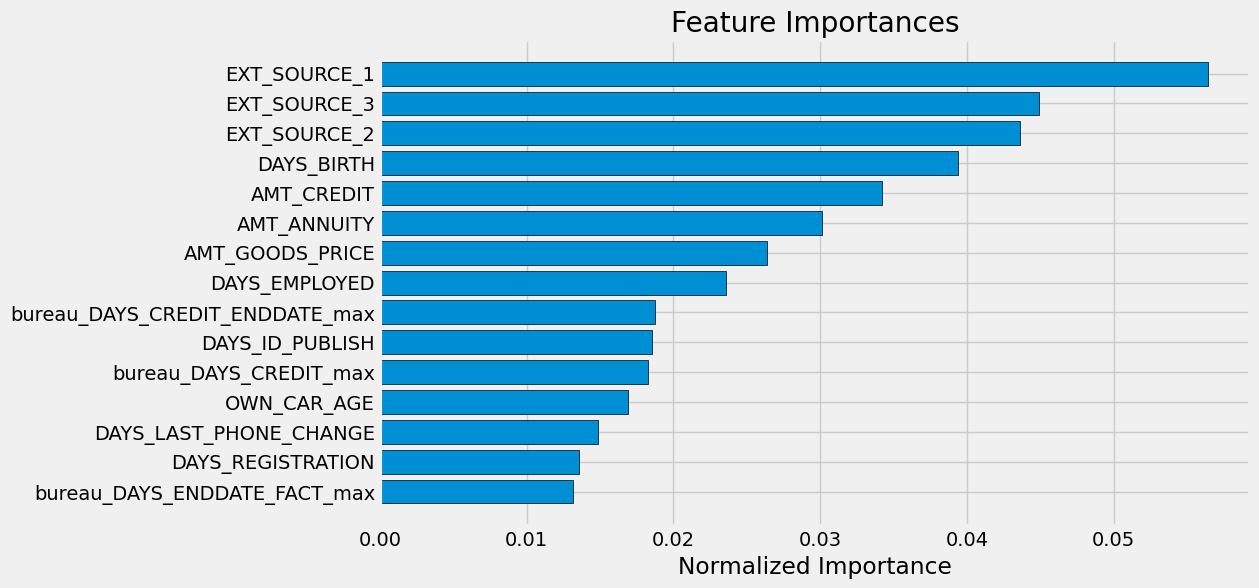

In [90]:
fi_raw_sorted = plot_feature_importances(fi_raw)

En examinant l'importance des features, il semble que quelques-unes des features que nous avons construites figurent parmi les plus importantes. Calculons maintenant le pourcentage des 100 features les plus importants que nous avons créés dans ce notebook. Cependant, plutôt que de simplement les comparer aux features d'origine, nous devons les comparer aux features d'origine encodées en one-hot. Ces dernières sont déjà enregistrées pour nous dans `fi` (à partir des données d'origine).

In [91]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

% of Top 100 Features created from the bureau data = 52.00


Plus de la moitié des 100 features les plus importants ont été créés par nous ! Cela devrait nous donner confiance que tout le travail que nous avons réalisé en valait la peine.

In [ ]:
submission_raw.to_csv('test_one.csv', index=False)

__Le test un obtient un score de 0,759 lorsqu'il est soumis au concours.__

### Test Deux

C'était facile, faisons une autre exécution ! Comme précédemment, mais avec les variables fortement corrélées supprimées.

In [92]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

Training Data Shape:  (307511, 318)
Testing Data Shape:  (48744, 318)
[200]	train's auc: 0.807062	train's binary_logloss: 0.539926	valid's auc: 0.761756	valid's binary_logloss: 0.555974
[200]	train's auc: 0.807403	train's binary_logloss: 0.539835	valid's auc: 0.762487	valid's binary_logloss: 0.556178
[200]	train's auc: 0.806206	train's binary_logloss: 0.541195	valid's auc: 0.766958	valid's binary_logloss: 0.557491
[400]	train's auc: 0.83864	train's binary_logloss: 0.508571	valid's auc: 0.767384	valid's binary_logloss: 0.536782
[200]	train's auc: 0.806561	train's binary_logloss: 0.540767	valid's auc: 0.763308	valid's binary_logloss: 0.55613
[200]	train's auc: 0.807104	train's binary_logloss: 0.540208	valid's auc: 0.760759	valid's binary_logloss: 0.557688


In [93]:
metrics_corr

,fold,train,valid
0,0,0.819890,0.762222
1,1,0.816296,0.762811
2,2,0.835801,0.767546
3,3,0.807812,0.763488
4,4,0.823635,0.761030
5,overall,0.820687,0.763372


Ces résultats sont meilleurs que le groupe de contrôle, mais légèrement inférieurs aux features brutes.

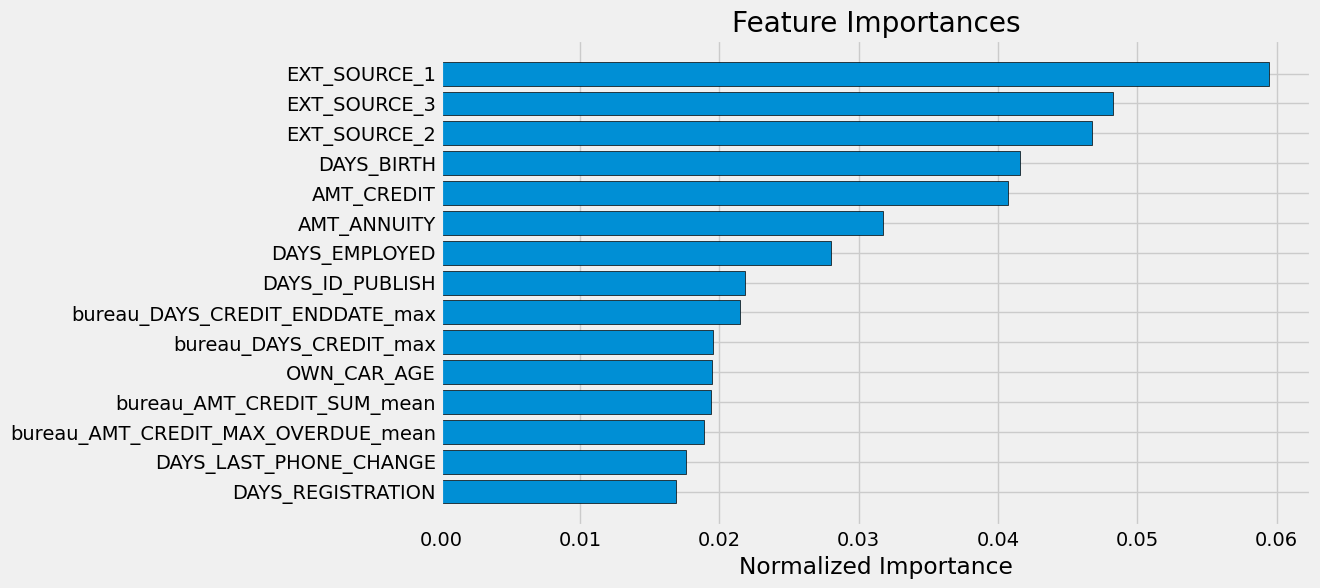

In [94]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [95]:
submission_corrs.to_csv('test_two.csv', index = False)

__Le test deux obtient un score de 0,753 lorsqu'il est soumis au concours.__

# Résultats

Après tout ce travail, nous pouvons dire que l'inclusion des informations supplémentaires a amélioré les performances ! Le modèle n'est certainement pas optimisé pour nos données, mais nous avons tout de même observé une amélioration significative par rapport à l'ensemble de données d'origine lors de l'utilisation des features calculées. Résumons officiellement les performances :

| __Expérience__ | __Score d'entraînement__ | __Score de validation__ | __Score de test__  |
|------------|-------|------------|-------|
| __Contrôle__    | 0,815 | 0,760      | 0,745 |
| __Test Un__   | 0,837 | 0,767      | 0,759 |
| __Test Deux__   | 0,826 | 0,765      | 0,753 |

(Notez que ces scores peuvent varier à chaque exécution du notebook. Cependant, je n'ai pas observé de changement dans l'ordre général des scores.)

Tout notre travail a permis une petite amélioration de 0,014 en termes de ROC AUC par rapport aux données de test d'origine. La suppression des variables fortement corrélées diminue légèrement les performances, nous devrons donc envisager une autre méthode de sélection des features. De plus, nous pouvons dire que certaines des features que nous avons construites sont parmi les plus importantes selon le modèle.

Dans un concours tel que celui-ci, même une amélioration de cette taille suffit à nous propulser de plusieurs centaines de places dans le classement. En réalisant de nombreuses petites améliorations comme dans ce notebook, nous pouvons progressivement obtenir de meilleures performances. J'encourage les autres à utiliser les résultats ici pour apporter leurs propres améliorations, et je continuerai à documenter les étapes que je prends pour aider les autres.

## Prochaines étapes

Pour aller de l'avant, nous pouvons maintenant utiliser les fonctions que nous avons développées dans ce notebook sur les autres ensembles de données. Il reste encore 4 autres fichiers de données à utiliser dans notre modèle ! Dans le prochain notebook, nous incorporerons les informations de ces autres fichiers de données (qui contiennent des informations sur les prêts précédents chez Home Credit) dans nos données d'entraînement. Ensuite, nous pourrons construire le même modèle et effectuer davantage d'expériences pour déterminer l'effet de notre ingénierie de features. Il y a encore beaucoup de travail à faire dans cette compétition et de nombreuses améliorations de performances à réaliser ! Rendez-vous dans le prochain notebook.